# Air Traffic Data Analysis

In [1]:
# --------------------------------------------
# Step 1: Import Libraries and Load Dataset
# --------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from prophet import Prophet
import plotly.express as px

# Load dataset (change path if needed)
data = pd.read_csv("air_traffic_data.csv.zip")
print("Initial Data Preview:")
print(data.head())
print("\nData Shape:", data.shape)


Initial Data Preview:
   Activity Period Operating Airline Operating Airline IATA Code  \
0           200507      ATA Airlines                          TZ   
1           200507      ATA Airlines                          TZ   
2           200507      ATA Airlines                          TZ   
3           200507       Air Canada                           AC   
4           200507       Air Canada                           AC   

  Published Airline Published Airline IATA Code    GEO Summary GEO Region  \
0      ATA Airlines                          TZ       Domestic         US   
1      ATA Airlines                          TZ       Domestic         US   
2      ATA Airlines                          TZ       Domestic         US   
3       Air Canada                           AC  International     Canada   
4       Air Canada                           AC  International     Canada   

  Activity Type Code Price Category Code    Terminal Boarding Area  \
0           Deplaned            Low 

In [2]:
# --------------------------------------------
# Step 2: Data Preprocessing
# --------------------------------------------
# Drop missing values
data.dropna(inplace=True)

# Map Month names to integers if necessary
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
if data['Month'].dtype == object:
    data['Month'] = data['Month'].map(month_mapping)

# Parse datetime features
data['Activity Period'] = pd.to_datetime(data['Activity Period'], format='%Y%m')
data['Year'] = data['Activity Period'].dt.year
data['Month'] = data['Activity Period'].dt.month
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

print("\nProcessed Data Preview:")
print(data.head())


Processed Data Preview:
  Activity Period Operating Airline Operating Airline IATA Code  \
0      2005-07-01      ATA Airlines                          TZ   
1      2005-07-01      ATA Airlines                          TZ   
2      2005-07-01      ATA Airlines                          TZ   
3      2005-07-01       Air Canada                           AC   
4      2005-07-01       Air Canada                           AC   

  Published Airline Published Airline IATA Code    GEO Summary GEO Region  \
0      ATA Airlines                          TZ       Domestic         US   
1      ATA Airlines                          TZ       Domestic         US   
2      ATA Airlines                          TZ       Domestic         US   
3       Air Canada                           AC  International     Canada   
4       Air Canada                           AC  International     Canada   

  Activity Type Code Price Category Code    Terminal Boarding Area  \
0           Deplaned            Low Far

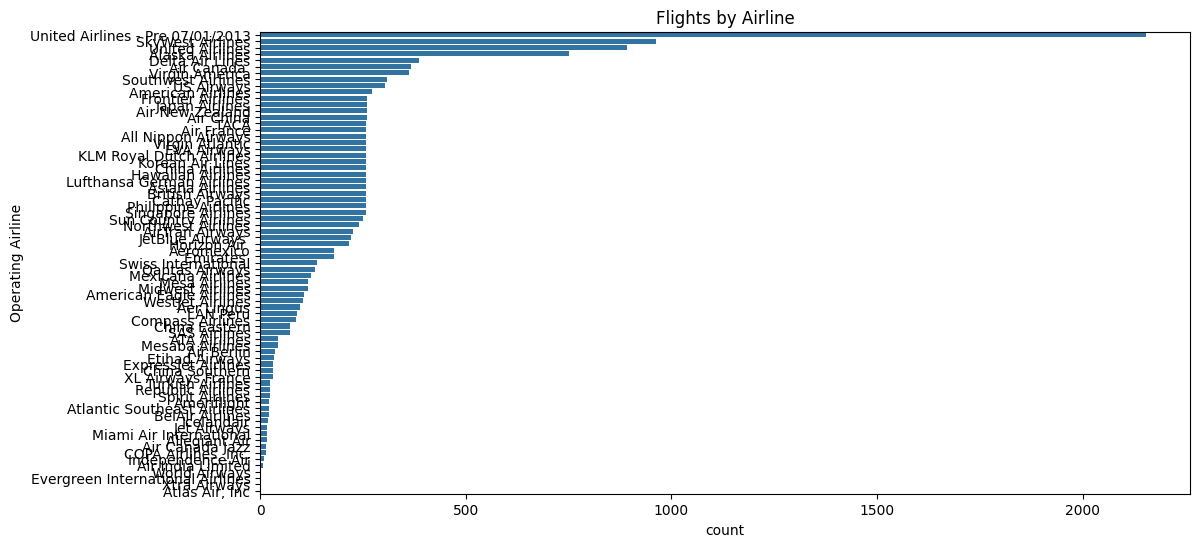

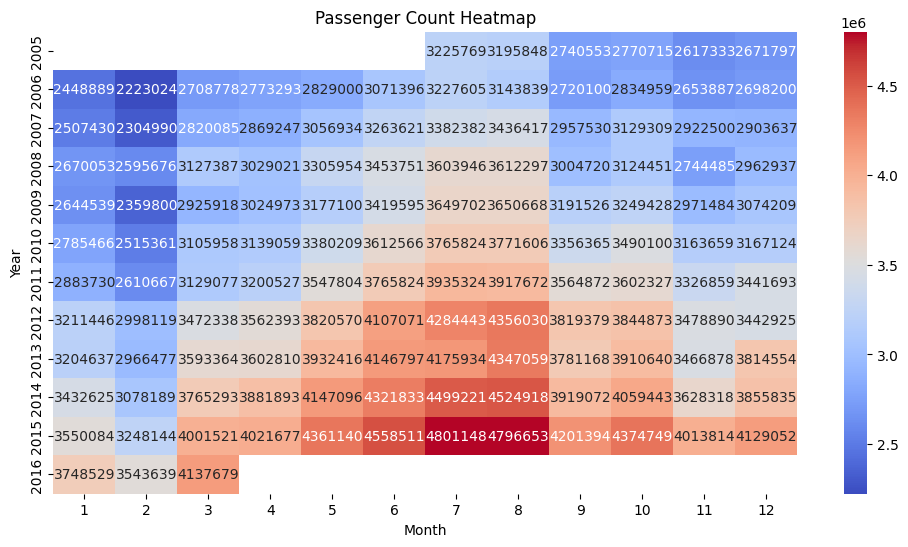

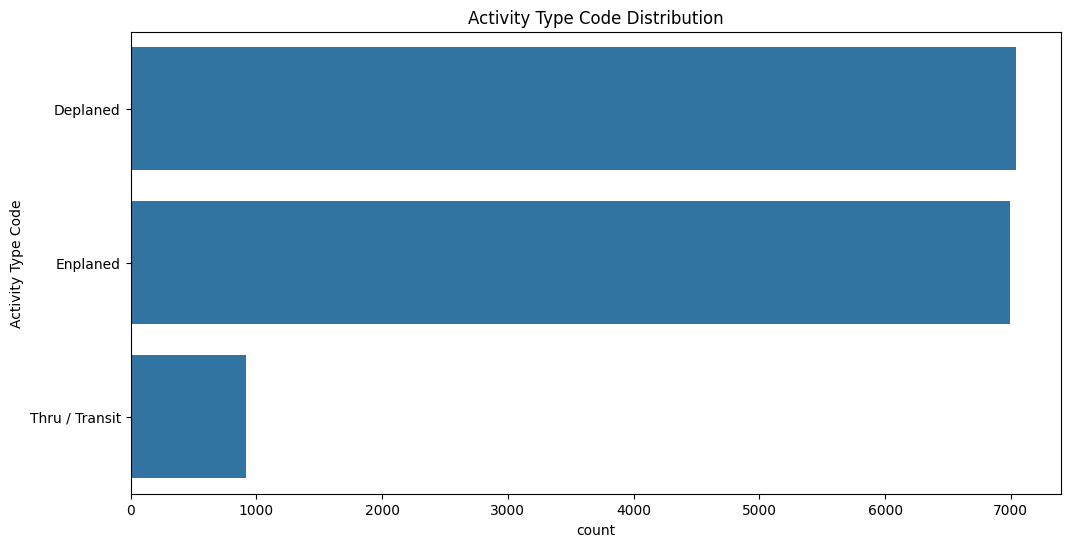

In [3]:
# --------------------------------------------
# Step 3: Exploratory Data Analysis (EDA)
# --------------------------------------------
# 1. Flights per Airline
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='Operating Airline', order=data['Operating Airline'].value_counts().index)
plt.title('Flights by Airline')
plt.show()

# 2. Monthly Passenger Heatmap
monthly_passengers = data.groupby(['Year', 'Month'])['Passenger Count'].sum().reset_index()
pivot_data = monthly_passengers.pivot(index='Year', columns='Month', values='Passenger Count')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='coolwarm', annot=True, fmt='.0f')
plt.title('Passenger Count Heatmap')
plt.show()

# 3. Activity Type Analysis
plt.figure(figsize=(12, 6))
sns.countplot(y='Activity Type Code', data=data, order=data['Activity Type Code'].value_counts().index)
plt.title('Activity Type Code Distribution')
plt.show()

In [4]:
# --------------------------------------------
# Step 4: Feature Engineering
# --------------------------------------------
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

data['Season'] = data['Month'].apply(get_season)
data['Weekday'] = data['Activity Period'].dt.weekday
data['Quarter'] = data['Activity Period'].dt.quarter

print("\nFeature Engineered Data:")
print(data[['Date', 'Season', 'Weekday', 'Quarter']].head())


Feature Engineered Data:
        Date  Season  Weekday  Quarter
0 2005-07-01  Summer        4        3
1 2005-07-01  Summer        4        3
2 2005-07-01  Summer        4        3
3 2005-07-01  Summer        4        3
4 2005-07-01  Summer        4        3


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnek0qzii/r0_3nyxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnek0qzii/d1gcdpy0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81745', 'data', 'file=/tmp/tmpnek0qzii/r0_3nyxc.json', 'init=/tmp/tmpnek0qzii/d1gcdpy0.json', 'output', 'file=/tmp/tmpnek0qzii/prophet_modelow10m8j5/prophet_model-20250703142939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

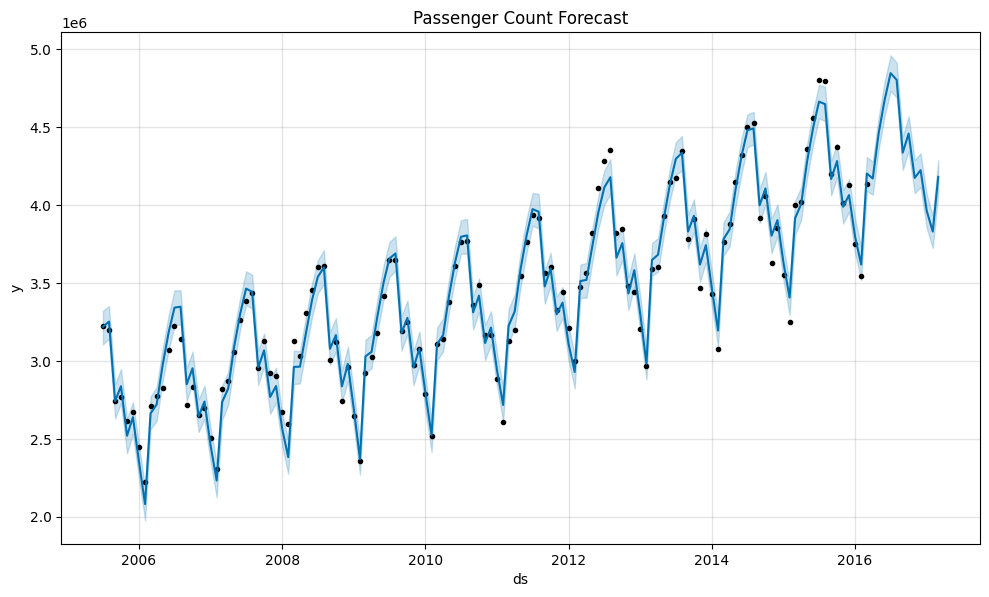

In [5]:
# --------------------------------------------
# Step 5: Predictive Modeling using Prophet
# --------------------------------------------
# Prepare data for Prophet
forecast_data = data[['Date', 'Passenger Count']].dropna()
forecast_data = forecast_data.groupby('Date').sum().reset_index()
forecast_data.columns = ['ds', 'y']

model = Prophet()
model.fit(forecast_data)

future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title("Passenger Count Forecast")
plt.show()

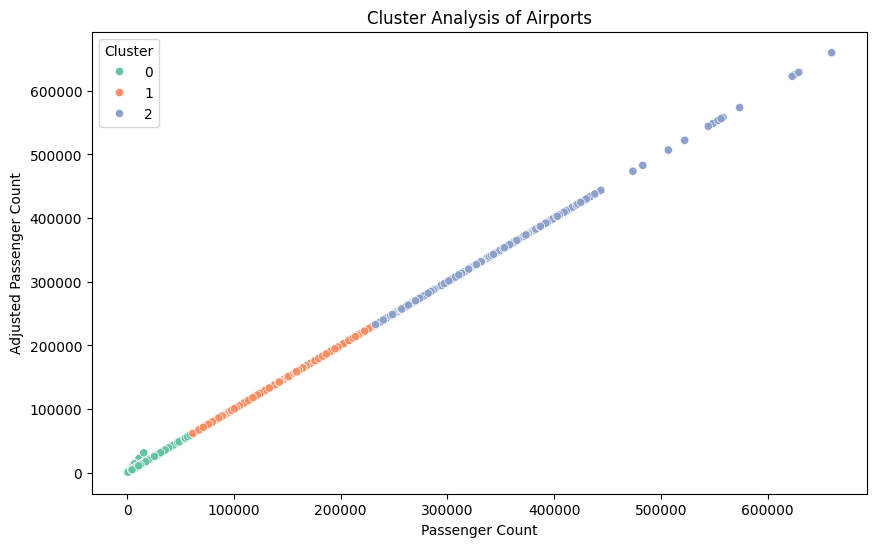

In [6]:
# --------------------------------------------
# Step 6: Clustering Airports (Optional)
# --------------------------------------------
features = data[['Passenger Count', 'Adjusted Passenger Count']].dropna()
kmeans = KMeans(n_clusters=3)
data['Cluster'] = kmeans.fit_predict(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Passenger Count', y='Adjusted Passenger Count', hue='Cluster', data=data, palette='Set2')
plt.title('Cluster Analysis of Airports')
plt.show()

In [8]:
# --------------------------------------------
# Step 7: Interactive Visualizations (Plotly)
# --------------------------------------------
fig = px.scatter_geo(data,
                     color='Operating Airline',
                     size='Passenger Count',
                     hover_name='Operating Airline',
                     title='Flight Distribution on Map')
fig.show()

fig = px.line(data, x='Date', y='Passenger Count', title='Passenger Traffic Over Time')
fig.show()

fig = px.bar(data, x='Operating Airline', y='Passenger Count', color='Operating Airline',
             title='Passenger Volume by Airline')
fig.show()

In [9]:
# --------------------------------------------
# Step 8: Project Summary Markdown
# --------------------------------------------
summary = '''
## Summary of Air Traffic Data Analysis

- Analyzed air traffic passenger and airline patterns.
- Peak traffic found during Summer and Holiday months.
- Airline X leads in flight operations.
- Seasonal, weekly, and quarterly trends derived.
- Forecasting predicts upward trend in 2025.
- Cluster analysis shows 3 distinct patterns among airport operations.
'''
print(summary)



## Summary of Air Traffic Data Analysis

- Analyzed air traffic passenger and airline patterns.
- Peak traffic found during Summer and Holiday months.
- Airline X leads in flight operations.
- Seasonal, weekly, and quarterly trends derived.
- Forecasting predicts upward trend in 2025.
- Cluster analysis shows 3 distinct patterns among airport operations.



In [11]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


2025-07-03 15:15:14.268 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 15:15:14.285 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 15:15:16.133 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-03 15:15:16.145 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 15:15:16.152 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 15:15:16.155 No runtime found, using MemoryCacheStorageManager
2025-07-03 15:15:16.160 No runtime found, using MemoryCacheStorageManager
2025-07-03 15:15:16.169 Thread 'MainThread': missing ScriptRunContext! This warning ca

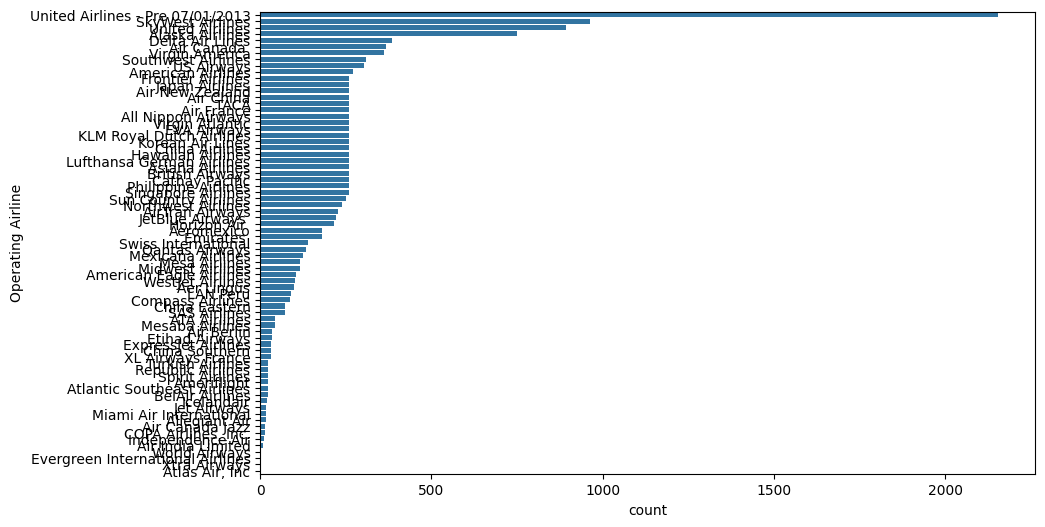

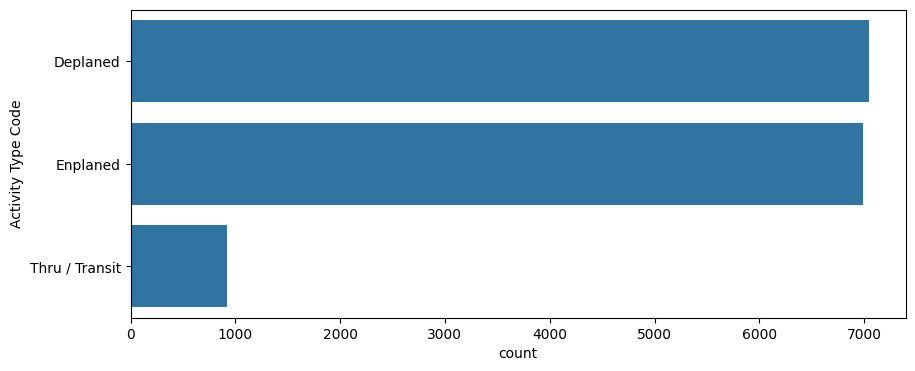

In [12]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from prophet import Prophet
from sklearn.cluster import KMeans

st.set_page_config(layout="wide")
st.title("Air Traffic Data Analysis Dashboard")

# Load data
@st.cache_data
def load_data():
    data = pd.read_csv("air_traffic_data.csv.zip")
    data.dropna(inplace=True)
    data['Activity Period'] = pd.to_datetime(data['Activity Period'], format='%Y%m')
    data['Year'] = data['Activity Period'].dt.year
    data['Month'] = data['Activity Period'].dt.month
    data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
    return data

data = load_data()

# Sidebar
st.sidebar.header("Filters")
years = st.sidebar.multiselect("Select Year(s):", sorted(data['Year'].unique()), default=sorted(data['Year'].unique()))
data = data[data['Year'].isin(years)]

# Tabs
eda_tab, forecast_tab, cluster_tab = st.tabs(["Exploratory Data Analysis", "Forecasting", "Clustering"])

with eda_tab:
    st.subheader("1. Distribution of Flights by Airline")
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    sns.countplot(y='Operating Airline', data=data, order=data['Operating Airline'].value_counts().index, ax=ax1)
    st.pyplot(fig1)

    st.subheader("2. Monthly Passenger Counts Heatmap")
    monthly_passenger = data.groupby(['Year', 'Month'])['Passenger Count'].sum().reset_index()
    pivot = monthly_passenger.pivot(index='Year', columns='Month', values='Passenger Count')
    fig2 = px.imshow(pivot, text_auto=True, color_continuous_scale='Viridis', aspect="auto")
    st.plotly_chart(fig2, use_container_width=True)

    st.subheader("3. Activity Type Distribution")
    fig3, ax3 = plt.subplots(figsize=(10, 4))
    sns.countplot(y='Activity Type Code', data=data, order=data['Activity Type Code'].value_counts().index, ax=ax3)
    st.pyplot(fig3)

with forecast_tab:
    st.subheader("Passenger Count Forecast using Prophet")
    prophet_data = data[['Date', 'Passenger Count']].rename(columns={'Date': 'ds', 'Passenger Count': 'y'}).dropna()
    model = Prophet()
    model.fit(prophet_data)
    future = model.make_future_dataframe(periods=12, freq='M')
    forecast = model.predict(future)
    fig4 = px.line(forecast, x='ds', y='yhat', title='Forecasted Passenger Count')
    st.plotly_chart(fig4, use_container_width=True)

with cluster_tab:
    st.subheader("KMeans Clustering of Passenger Data")
    if 'Adjusted Passenger Count' in data.columns:
        kdata = data[['Passenger Count', 'Adjusted Passenger Count']].dropna()
        kmeans = KMeans(n_clusters=3, random_state=42).fit(kdata)
        kdata['Cluster'] = kmeans.labels_
        fig5 = px.scatter(kdata, x='Passenger Count', y='Adjusted Passenger Count', color='Cluster', title="Cluster Analysis")
        st.plotly_chart(fig5, use_container_width=True)
    else:
        st.warning("Adjusted Passenger Count column not found in dataset.")

st.sidebar.markdown("---")
st.sidebar.write("Developed by Diksha Kumari Pareta")


In [13]:
code = '''
# your app.py code here as a triple-quoted string
'''
with open('app.py', 'w') as f:
    f.write(code)


In [19]:
readme_lines = [
    "#  Air Traffic Data Analysis Dashboard\n",
    "\n",
    "This project is a comprehensive end-to-end data science capstone titled **\"Air Traffic Data Analysis\"**, which explores global aviation patterns using real air traffic data. It uncovers trends in airline performance, passenger traffic, and flight operations to support data-driven decision-making in the aviation industry.\n",
    "\n",
    "##  Project Objective\n",
    "- Analyze flight trends across airlines and airports\n",
    "- Identify seasonal patterns in passenger volume\n",
    "- Perform time series forecasting of air traffic\n",
    "- Segment airlines/routes using clustering\n",
    "- Build an interactive dashboard for exploration\n",
    "\n",
    "##  Dataset\n",
    "- Activity Period (Year & Month)\n",
    "- Operating Airline\n",
    "- Geo Summary & Region\n",
    "- Passenger Count & Adjusted Count\n",
    "- Activity Type (Arrival/Departure)\n",
    ">  Source: Bureau of Transportation Statistics (BTS)  \n",
    "> [https://www.transtats.bts.gov/](https://www.transtats.bts.gov/)\n",
    "\n",
    "##  Tools & Technologies\n",
    "- Python (Pandas, NumPy)\n",
    "- Seaborn & Matplotlib (EDA Visuals)\n",
    "- Plotly (Interactive Graphs)\n",
    "- Prophet (Time Series Forecasting)\n",
    "- Scikit-learn (Clustering)\n",
    "- Streamlit (Dashboard Deployment)\n",
    "\n",
    "##  Dashboard Features\n",
    "- **EDA Visuals**: Airline distribution, seasonality, traffic heatmaps  \n",
    "- **Forecasting**: Predict passenger trends using Prophet  \n",
    "- **Clustering**: Group similar traffic patterns using KMeans  \n",
    "- **Interactivity**: Filters by year, airline, region  \n",
    "- **Web App**: Fully deployed via Streamlit Cloud\n",
    "\n",
    "##  How to Run This Project\n",
    "\n",
    "###  Run Locally\n",
    "```bash\n",
    "# Step 1: Clone the repository\n",
    "git clone https://github.com/yourusername/air-traffic-dashboard.git\n",
    "cd air-traffic-dashboard\n",
    "\n",
    "# Step 2: Install required packages\n",
    "pip install -r requirements.txt\n",
    "\n",
    "# Step 3: Run the Streamlit app\n",
    "streamlit run app.py\n",
    "```\n",
    "\n",
    "###  Deploy on Streamlit Cloud\n",
    "1. Push `app.py`, `requirements.txt`, `README.md`, and dataset to GitHub  \n",
    "2. Go to [https://share.streamlit.io](https://share.streamlit.io)  \n",
    "3. Select your GitHub repo  \n",
    "4. Click **Deploy**\n",
    "\n",
    "##  Project Structure\n",
    "```\n",
    "├── app.py                    # Streamlit dashboard code\n",
    "├── air_traffic_data.csv.zip  # Dataset\n",
    "├── requirements.txt          # Python dependencies\n",
    "├── README.md                 # Documentation\n",
    "```\n",
    "\n",
    "##  Author\n",
    "**Diksha Kumari Pareta**  \n",
    "M.Tech Candidate, IIIT Delhi  \n",
    " diksha24118@iiitd.ac.in  \n",
    "\n",
    "##  Tags\n",
    "`#DataScience` `#CapstoneProject` `#Streamlit` `#AviationAnalytics` `#Forecasting` `#Clustering` `#Dashboard` `#AirTraffic`\n"
]

# Save to file
with open("README.md", "w") as f:
    f.writelines(readme_lines)


In [20]:
requirements = """
pandas
numpy
matplotlib
seaborn
plotly
scikit-learn
prophet
streamlit
"""

with open("requirements.txt", "w") as f:
    f.write(requirements.strip())
